In [1]:
import numpy as np
import numpy.random as npr
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import xarray as xr
import seaborn as sns
import os
from convection_param.Constants import label_remapping
import pickle
from convection_param.setup_mpl_tex import setup_mpl_tex, set_size

%load_ext autoreload
%autoreload 2

In [2]:
data_path = '../../Models/NewFormat/Torch/20230415-021732R2B5_vlr_unet_adam_lr0.0003_y13y16full_fluxes_prescaledeps1_wqrqstend_worhoprestemp_torch_rhofluct_alldays_hpoed/TestPredictions.npz'
data = np.load(data_path)
model_name = os.path.basename(os.path.dirname(data_path))
print(data.files)
Y_test, Y_pred, X_expl, Y_expl = data['Y_test'], data['Y_pred'], data['X_expl'], data['Y_expl']

['Y_test', 'Y_pred', 'X_expl', 'Y_expl']


In [3]:
train_data_path = '../../local_data/TrainData/20230131-171851-R2B5_y13y16_vcg-fluxes_rho_fluct.npz'
train_data = np.load(train_data_path)
print(train_data.files)
test_coords = train_data['test_coords']

['X_train', 'X_val', 'X_test', 'Y_train', 'Y_val', 'Y_test', 'X_expl', 'Y_expl', 'train_coords', 'val_coords', 'test_coords']


In [4]:
Y_pred_gbt = np.load('../Models/from080622/20230421-1613616samples/HistGradientBoostingRegressor/test_preds.npz')['Y_test_pred']
# Y_pred_gbt = Y_test.copy() + npr.normal(size=Y_test.shape)
print(Y_pred_gbt.shape)
print(Y_pred.shape)

(201702, 189)
(201702, 189)


In [6]:
import pickle
from convection_param.HelperFuncs import StandardScalerOneVar

# with open('scalerdict_X.pickle', 'rb') as handle:
with open('../../local_data/TrainData/20230131-171851-R2B5_y13y16_vcg-fluxes_rho_fluct_scalerdict_X.pickle', 'rb') as handle:
    scalerdict_X = pickle.load(handle)

# with open('scalerdict_Y.pickle', 'rb') as handle:
with open('../../local_data/TrainData/20230131-171851-R2B5_y13y16_vcg-fluxes_rho_fluct_scalerdict_Y.pickle', 'rb') as handle:
    scalerdict_Y = pickle.load(handle)
    
with open('../../local_data/TrainData/20230111-165428-R2B5_y13y16_vcg-fluxes_rho_fluct_Ymask.pickle', 'rb') as handle:
    Y_mask = pickle.load(handle)

# mean_rel_err = (Y_pred - Y_test) / Y_test
# mean_rel_err_gbt = (Y_pred_gbt - Y_test) / Y_test
# plt.hist(np.clip(mean_rel_err.ravel(), -1000, 1000), bins=100, log=True, alpha=0.5, label='unet')
# plt.hist(np.clip(mean_rel_err_gbt.ravel(), -1000, 1000), bins=100, log=True, alpha=0.5, label='rf')
# plt.legend()
# plt.show()

In [7]:
from sklearn.metrics import r2_score, mean_squared_error, d2_pinball_score
from convection_param.HelperFuncs import calc_correlation, compute_correlation_per_var
import datetime

R2_all = r2_score(Y_test, Y_pred, multioutput='raw_values')
R2_varw = r2_score(Y_test[:,Y_mask], Y_pred[:,Y_mask], multioutput='variance_weighted')
MSE = mean_squared_error(Y_test[:,Y_mask], Y_pred[:,Y_mask])
Corr_varw = compute_correlation_per_var(Y_test[:,Y_mask], Y_pred[:,Y_mask], multioutput='variance_weighted')
print(R2_varw)
print(MSE)
print(Corr_varw)

R2_all_gbt = r2_score(Y_test, Y_pred_gbt, multioutput='raw_values')
print(r2_score(Y_test[:,Y_mask], Y_pred_gbt[:,Y_mask], multioutput='variance_weighted'))

0.898280172996608
0.12560661
0.9399669547729596
0.8352374742857839


In [8]:
# Comparison of R2 for 2d fields
print(R2_all[-5:])
print(R2_all_gbt[-5:])

[0.77765778 0.79819328 0.85025293 0.85311284 0.89790093]
[0.72719473 0.75088062 0.76951096 0.81261082 0.86004958]


# Plot Pred/Target Distribution/Scatter

In [9]:
from convection_param.HelperFuncs import unique_unsorted

Y_test_unnorm = Y_test.copy()
Y_pred_unnorm = Y_pred.copy()
Y_pred_gbt_unnorm = Y_pred_gbt.copy()
idx0 = 0
for var, idx_range in zip(*unique_unsorted([e[0] for e in Y_expl], return_counts=True)):
    print(var,idx0,idx0+idx_range)
    scaler = scalerdict_Y[var]
    Y_test_unnorm[...,idx0:idx0+idx_range] = scaler.inverse_transform(Y_test_unnorm[...,idx0:idx0+idx_range])
    Y_pred_unnorm[...,idx0:idx0+idx_range] = scaler.inverse_transform(Y_pred_unnorm[...,idx0:idx0+idx_range])
    Y_pred_gbt_unnorm[...,idx0:idx0+idx_range] = scaler.inverse_transform(Y_pred_gbt_unnorm[...,idx0:idx0+idx_range])
    idx0 += idx_range

subg_flux_qv 0 23
subg_flux_qc 23 46
subg_flux_qi 46 69
subg_flux_qr 69 92
subg_flux_qs 92 115
subg_flux_h 115 138
subg_flux_u 138 161
subg_flux_v 161 184
clt 184 185
cltp 185 186
liq_detri 186 187
ice_detri 187 188
tot_prec 188 189


### Test

In [23]:
X_train = train_data['X_train']
X_train.shape

(1613616, 23, 9)

In [25]:
X_train_unnorm = X_train.copy()
idx0 = 0
for i,(key,scaler) in enumerate(scalerdict_X.items()):
    print(X_expl[i*23])
    print(key)
    X_train_unnorm[:,:,i] = scaler.inverse_transform(X_train_unnorm[:,:,i])
    # idx0 += idx_range

['w_fl' '9']
w_fl
['qv' '9']
qv
['qc' '9']
qc
['qi' '9']
qi
['qr' '9']
qr
['qs' '9']
qs
['u' '9']
u
['v' '9']
v
['h' '9']
h


Minimal scale btw. qv and qr:  283.83034456435985
Minimal scale btw. qv and qs:  6.495877367217855
-59.01910596920261


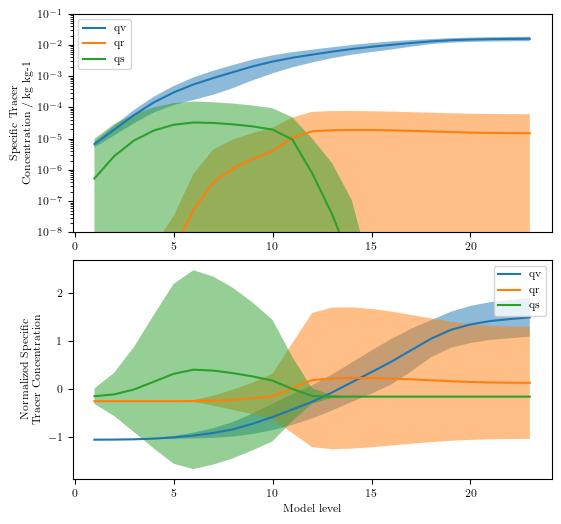

In [68]:
from convection_param.setup_mpl_tex import setup_mpl_tex, set_size, get_ax_size

setup_mpl_tex()
figsize = list(set_size('textwidth'))
figsize[1] += 1
fig, axes = plt.subplots(2, 1, figsize=figsize, constrained_layout=True)

ax = axes[0]

mean_unnorm_qv = np.mean(X_train_unnorm[:,:,1], axis=0)
std_unnorm_qv = np.std(X_train_unnorm[:,:,1], axis=0)
mean_unnorm_qr = np.mean(X_train_unnorm[:,:,4], axis=0)
std_unnorm_qr = np.std(X_train_unnorm[:,:,4], axis=0)
mean_unnorm_qs = np.mean(X_train_unnorm[:,:,5], axis=0)
std_unnorm_qs = np.std(X_train_unnorm[:,:,5], axis=0)
x = range(1,len(mean_unnorm_qv)+1)

ax.plot(x, mean_unnorm_qv, label='qv')
ax.fill_between(x, mean_unnorm_qv-std_unnorm_qv, mean_unnorm_qv+std_unnorm_qv, alpha=0.5)
ax.plot(x, mean_unnorm_qr, label='qr')
ax.fill_between(x, mean_unnorm_qr-std_unnorm_qr, mean_unnorm_qr+std_unnorm_qr, alpha=0.5)
ax.plot(x, mean_unnorm_qs, label='qs')
ax.fill_between(x, mean_unnorm_qs-std_unnorm_qs, mean_unnorm_qs+std_unnorm_qs, alpha=0.5)
print('Minimal scale btw. qv and qr: ', np.min(mean_unnorm_qv/mean_unnorm_qr))
print('Minimal scale btw. qv and qs: ', np.min(mean_unnorm_qv/mean_unnorm_qs))

ax.set_yscale('log')
ax.set_ylim(1e-8, 1e-1)

# ax.set_xlabel('Model level')
ax.set_ylabel('Specific Tracer\nConcentration / kg kg-1')

ax.legend()

ax = axes[1]

mean_qv = np.mean(X_train[:,:,1], axis=0)
std_qv = np.std(X_train[:,:,1], axis=0)
mean_qr = np.mean(X_train[:,:,4], axis=0)
std_qr = np.std(X_train[:,:,4], axis=0)
mean_qs = np.mean(X_train[:,:,5], axis=0)
std_qs = np.std(X_train[:,:,5], axis=0)
x = range(1,len(mean_qv)+1)

ax.plot(x, mean_qv, label='qv')
ax.fill_between(x, mean_qv-std_qv, mean_qv+std_qv, alpha=0.5)
ax.plot(x, mean_qr, label='qr')
ax.fill_between(x, mean_qr-std_qr, mean_qr+std_qr, alpha=0.5)
ax.plot(x, mean_qs, label='qs')
ax.fill_between(x, mean_qs-std_qs, mean_qs+std_qs, alpha=0.5)
print(np.min(mean_qv/mean_qs))
# ax.yscale('log')
# ax.ylim(1e-8, 1e-1)
ax.set_xlabel('Model level')
ax.set_ylabel('Normalized Specific\nTracer Concentration')

ax.legend()

# fig.savefig('../../Figures/Pdfplots/Revision2_qvqrqs_mean-std_profiles.pdf')

plt.show()